In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet101, EfficientNetB7
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.models import Model

In [ ]:
! nvidia-smi

Sat Jun  8 08:14:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
dataset_dir = 'drive/MyDrive/JBNU/dataset'

img_height = 150
img_width = 150

images = []
labels = []
class_names = []

for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_dir):
        class_names.append(class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            try:
                img = Image.open(img_path).resize((img_width, img_height)).convert('RGB')
                images.append(img)
                labels.append(class_name)
            except Exception as e:
                print(f"Erreur lors du traitement de l'image {img_path}: {e}")



In [ ]:

images = np.array([np.array(img) for img in images])
labels = np.array(labels)

print(f"Nombre d'images chargées: {len(images)}")
print(f"Labels: {len(labels)}")

Nombre d'images chargées: 6603
Labels: 6603


In [ ]:
print(len(labels))
label_binarizer = LabelBinarizer()
y = label_binarizer.fit_transform(labels)

x_train, x_test, y_train, y_test = train_test_split(images, y, test_size=0.2, random_state=123)

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")
print(f"Class names: {label_binarizer.classes_}")


6603
x_train shape: (5282, 150, 150, 3), y_train shape: (5282, 11)
x_test shape: (1321, 150, 150, 3), y_test shape: (1321, 11)
Class names: ['dew' 'fogsmog' 'frost' 'glaze' 'hail' 'lightning' 'rain' 'rainbow'
 'rime' 'sandstorm' 'snow']


In [ ]:

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (5282, 150, 150, 3)
y_train shape: (5282, 11)
x_test shape: (1321, 150, 150, 3)
y_test shape: (1321, 11)


In [ ]:
epochs = 10
batch_size = 32

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)

In [ ]:
base_model_efficientnet = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(img_height, img_height, 3))

x = base_model_efficientnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(11, activation='softmax')(x)

model_efficientnet = Model(inputs=base_model_efficientnet.input, outputs=predictions)

opt = keras.optimizers.Adam(lr=0.001)
model_efficientnet.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


print(model_efficientnet.summary())

258076736/258076736 [==============================] - 2s 0us/step


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 150, 150, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 150, 150, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 150, 150, 3)          0         ['normalization[0][0]']   

In [ ]:
images = []
history_efficientnet = model_efficientnet.fit(train_generator,
                                              steps_per_epoch=len(x_train) // batch_size,
                                              epochs=epochs,
                                              validation_data=(x_test, y_test)
                                             )

Epoch 1/10
165/165 [==============================] - 294s 899ms/step - loss: 0.9794 - accuracy: 0.6859 - val_loss: 4.5483 - val_accuracy: 0.1045
Epoch 2/10
165/165 [==============================] - 142s 859ms/step - loss: 0.6491 - accuracy: 0.7943 - val_loss: 3.7355 - val_accuracy: 0.0833
Epoch 3/10
165/165 [==============================] - 139s 844ms/step - loss: 0.5764 - accuracy: 0.8152 - val_loss: 3.3426 - val_accuracy: 0.0583
Epoch 4/10
165/165 [==============================] - 142s 858ms/step - loss: 0.5064 - accuracy: 0.8373 - val_loss: 4.1387 - val_accuracy: 0.1173
Epoch 5/10
165/165 [==============================] - 142s 858ms/step - loss: 0.4467 - accuracy: 0.8583 - val_loss: 2.5603 - val_accuracy: 0.3338
Epoch 6/10
165/165 [==============================] - 139s 843ms/step - loss: 0.4237 - accuracy: 0.8657 - val_loss: 3.0336 - val_accuracy: 0.1325
Epoch 7/10
165/165 [==============================] - 141s 861ms/step - loss: 0.4709 - accuracy: 0.8482 - val_loss: 3.9095 -

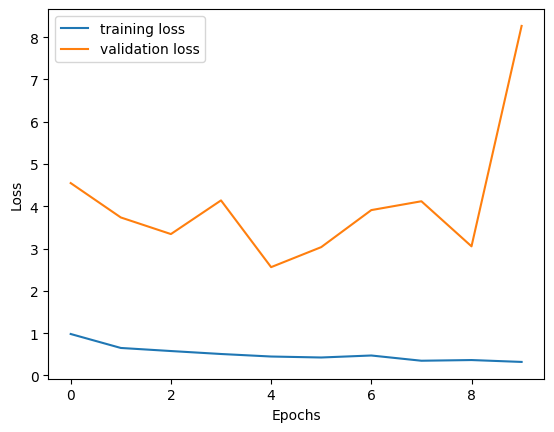

In [ ]:
plt.plot(history_efficientnet.history['loss'], label='training loss')
plt.plot(history_efficientnet.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
x_train=[]
y_train =[]
test_loss_efficientnet, test_acc_efficientnet = model_efficientnet.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy with EfficientNetB7:', test_acc_efficientnet)

42/42 - 8s - loss: 8.2650 - accuracy: 0.1030 - 8s/epoch - 182ms/step

Test accuracy with EfficientNetB7: 0.10295230895280838
